In [2]:
import torch 
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.preprocessing import MaxAbsScaler, MinMaxScaler

In [3]:
def modal_sum(w, a_n, z_n, w_n, sigma=0.1):
    tf = np.zeros_like(w, dtype=np.complex128)
    for i in range(len(a_n)):
        tf += a_n[i] / (w_n[i]**2 - w**2 + 1j * 2 * z_n[i] * w * w_n[i])
    noise = np.random.normal(0, sigma, len(w)) + 1j * np.random.normal(0, sigma, len(w))
    tf += noise

    y = np.zeros(len(w))
    for i, w_n_value in enumerate(w_n):
        closest_index = np.argmin(np.abs(w - w_n_value))
        y[closest_index] = 1
        
        dw = w_n_value * z_n[i] # Half power bandwidth
        indices_in_range = np.where((w > w_n_value - dw) & (w < w_n_value + dw))
        y[indices_in_range] = 1

    return tf, y

In [4]:
def to_db(x):
    if x.shape[-1] == 2:
        return 20 * np.log10(np.linalg.norm(x, axis=-1))
    return 20 * np.log10(np.abs(x))

In [5]:
def split_real_imag(x: np.ndarray) -> np.ndarray:
    return np.column_stack((np.real(x), np.imag(x)))

In [24]:
w  = np.arange(0, 10, 0.1)
a_n = np.array([1, 2, 3])
z_n = np.array([0.1, 0.2, 0.3])
w_n = np.array([1, 2, 3])


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]


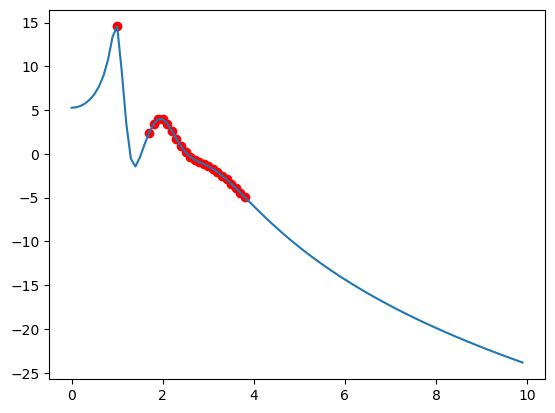

In [25]:
out, y = modal_sum(w, a_n, z_n, w_n, sigma = 0)
print(y)
plt.plot(w, to_db(out))
# plt.plot(w, out)
for i in range(len(w)):
    if y[i] == 1:
        plt.scatter(w[i], to_db(out)[i], c='red', marker='o')
plt.show()

In [6]:
def generate_data(num_data, num_w_points):
    X = []
    Y = []
    ws = []
    zs = []
    w = np.linspace(0, 1, num_w_points)
    for i in range(num_data):
        num_modes = np.random.randint(0, 5)
        w_n = np.random.uniform(0, 1, num_modes)
        a_n = np.random.uniform(1, 2, num_modes)
        z_n = np.random.uniform(0.01, 0.20, num_modes)
        sigma = np.random.uniform(0.01, 0.15)
        out, y = modal_sum(w, a_n, z_n, w_n, sigma)
        ws.append(w_n)
        zs.append(z_n)
        X.append(split_real_imag(out))
        Y.append(y)
    return np.array(X), np.array(Y), ws, zs

In [7]:
def plot_tf(tf, y, todb=True):
    fig, ax = plt.subplots()
    w = np.linspace(0, 1, len(y))
    if todb:
        ax.plot(w, to_db(tf))
        for i in range(len(w)):
            if y[i] == 1:
                ax.scatter(w[i], to_db(tf)[i], c='red', marker='o')
    else:
        tf_vals = np.linalg.norm(tf, axis=-1)
        ax.plot(w, tf_vals)
        for i in range(len(w)):
            if y[i] == 1:
                ax.scatter(w[i], tf_vals[i], c='red', marker='o')
    # plt.show()
    return fig, ax


In [8]:
class BiRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # calls parent class constructor
        super(BiRNN, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # hidden_size * 2 because we are using a bidirectional RNN (double the length of the hidden state)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        self.droput = nn.Dropout(0.3)
        
    def forward(self, x):
        out, _ = self.rnn(x)
        # Pass each time step's output through a fully connected layer
        out = self.fc(out)
        out = self.droput(out)
        # out = torch.sigmoid(out)
        return out

In [9]:
# Create a BiRNN
# input size is batch_size, seq_len, input_size (e.g. 1000 x 500 x 2 for 1000 training examples of 500 time steps with 2 features)
# hidden_size is the number of features in the hidden state

input_size = 2
hidden_size = 100
num_layers = 3
num_classes = 1 # binary classification
w_length = 200

[0.21218675 0.05795294]
[0.14850642 0.0733343 ]
(32, 200, 2)
(32, 200)
4.003909304143862


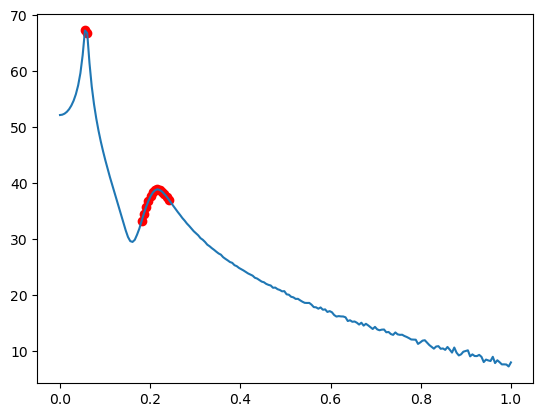

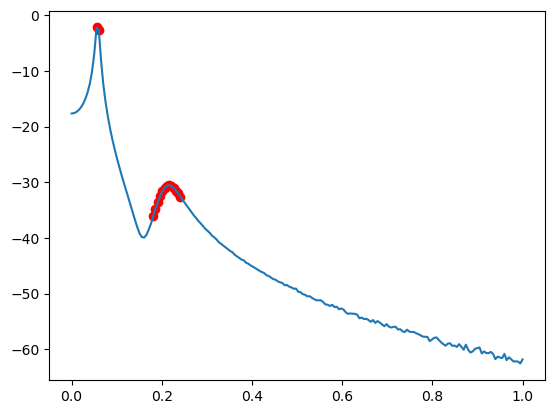

In [31]:
w = np.linspace(0, 1, w_length)
data_size = 32*1
X, y, ws, zs = generate_data(data_size, w_length)
# max_abs_scaler = MinMaxScaler()
# X = max_abs_scaler.fit_transform(X.reshape(-1, 2)).reshape(data_size, w_length, 2)

# print(X[0, :, 0])
# print(X[0,:,0].shape)

min_vals = np.min(X, axis=1, keepdims=True)
max_vals = np.max(X, axis=1, keepdims=True)
X_norm = (X - min_vals) / (max_vals - min_vals)

magntiude = np.linalg.norm(X, axis=1, keepdims=True)
X_norm2 = X / magntiude


plot_tf(X[0], y[0])
# plot_tf(X_norm[0], y[0])
plot_tf(X_norm2[0], y[0])
print(ws[0])
print(zs[0])
print(X.shape)
print(y.shape)
num_ones = np.mean(y.sum(axis=1))
print( (w_length - num_ones) / num_ones)

In [32]:
# X = torch.from_numpy(X).to(torch.float32)
# y = torch.from_numpy(y).to(torch.float32)

# # run cross validation
# kfold = KFold(n_splits=8, shuffle=True)
# accuracies = []
# for train, test in kfold.split(X, y):
#     # create model, train, and get accuracy
#     model = BiRNN(input_size, hidden_size, num_layers, num_classes)
#     acc = model_train(model, X[train], y[train], X[test], y[test], n_epochs=1)
#     print("Accuracy: %.2f" % acc)
#     accuracies.append(acc)
 
# # evaluate the model
# mean = np.mean(accuracies)
# std = np.std(accuracies)
# print("Baseline: %.2f%% (+/- %.2f%%)" % (mean*100, std*100))

In [10]:
def calculate_accuracy(outputs, targets):
    # Round the output to 0 or 1
    predicted = (outputs > 0.5).float()
    correct = (predicted == targets)
    accuracy = correct.sum().item() / len(targets)
    return accuracy


def calculate_precision_and_recall(outputs, targets):
    # Round the output to 0 or 1
    predicted = (outputs > 0.5).float()
    true_positives = (predicted * targets).sum().item()
    false_positives = (predicted * (1 - targets)).sum().item()
    false_negatives = ((1 - predicted) * targets).sum().item()
    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0
    return precision, recall

In [34]:
model = BiRNN(input_size, hidden_size, num_layers, num_classes)
X = torch.from_numpy(X_norm2).to(torch.float32)
y = torch.from_numpy(y).to(torch.float32)

dataset = TensorDataset(X, y)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Validation data
valX, valy, valws, valzs = generate_data(data_size, w_length)
val_X = torch.from_numpy(valX).to(torch.float32)
val_y = torch.from_numpy(valy).to(torch.float32)
val_dataset = TensorDataset(val_X, val_y)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)


# Define a binary cross-entropy loss function and an optimizer
# criterion = nn.BCELoss()  # Binary cross-entropy loss

# pos_weight > 1 aims to increase recall
criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([5.3]))  # Binary cross-entropy loss with logits
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 150
for epoch in range(num_epochs):
    total_loss = 0.0
    total_precision = 0.0
    total_recall = 0.0
    total_samples = 0

    total_val_precision = 0.0
    total_val_recall = 0.0
    total_val_samples = 0

    for inputs, targets in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        
        # Reshape the outputs and targets for the loss calculation
        outputs = outputs.view(-1, 1)  # Reshape to [batch_size * sequence_length, 1]
        targets = targets.view(-1, 1)
        
        loss = criterion(outputs, targets.float())  # Convert targets to float
        loss.backward()
        optimizer.step()
        
        # batch_accuracy = calculate_accuracy(outputs, targets)
        # total_loss += loss.item() * len(inputs)
        # total_accuracy += batch_accuracy * len(inputs)
        # total_samples += len(inputs)

        batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
        total_loss += loss.item() * len(inputs)
        total_precision += batch_precision * len(inputs)
        total_recall += batch_recall * len(inputs)
        total_samples += len(inputs)

    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            outputs = outputs.view(-1, 1)
            targets = targets.view(-1, 1)

            batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
            total_val_precision += batch_precision * len(inputs)
            total_val_recall += batch_recall * len(inputs)
            total_val_samples += len(inputs)

    average_loss = total_loss / total_samples
    average_precision = total_precision / total_samples
    average_recall = total_recall / total_samples
    # average_accuracy = total_accuracy / total_samples
    average_val_precision = total_val_precision / total_val_samples
    average_val_recall = total_val_recall / total_val_samples

    # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Accuracy: {average_accuracy}')
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Precision: {average_precision}, Recall: {average_recall}')
    print(f'Validation Precision: {average_val_precision}, Validation Recall: {average_val_recall}')

torch.save(model, 'precision_recall_model.pth')

Epoch [1/150], Loss: 1.2801098823547363, Precision: 0.0, Recall: 0.0
Validation Precision: 0.21765322158198008, Validation Recall: 0.7232375979112271
Epoch [2/150], Loss: 1.3343907594680786, Precision: 0.2023121387283237, Recall: 0.7114933541829555
Validation Precision: 0.4606741573033708, Validation Recall: 0.7136640557006092
Epoch [3/150], Loss: 1.2714961767196655, Precision: 0.7634408602150538, Recall: 0.05551211884284597
Validation Precision: 0.5522496371552975, Validation Recall: 0.6623150565709313
Epoch [4/150], Loss: 1.2754641771316528, Precision: 0.0, Recall: 0.0
Validation Precision: 0.5486432825943084, Validation Recall: 0.721496953872933
Epoch [5/150], Loss: 1.284806251525879, Precision: 0.0, Recall: 0.0
Validation Precision: 0.47794117647058826, Validation Recall: 0.6788511749347258
Epoch [6/150], Loss: 1.2804887294769287, Precision: 0.0, Recall: 0.0
Validation Precision: 0.38461538461538464, Validation Recall: 0.7136640557006092
Epoch [7/150], Loss: 1.2699640989303589, Pre

KeyboardInterrupt: 

In [11]:
def validate_data(num_batches, model):

    Xval, yval, _, __ = generate_data(32*num_batches,200)

    Xval = torch.from_numpy(Xval).to(torch.float32)
    yval = torch.from_numpy(yval).to(torch.float32)

    dataset = TensorDataset(Xval, yval)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    # total_validation_accuracy = 0.0
    # total_validation_samples = 0

    # # Iterate through the validation dataset and calculate accuracy
    # model.eval()
    # for val_inputs, val_targets in val_loader:
    #     with torch.no_grad():
    #         val_outputs = model(val_inputs)

    #     # Reshape the outputs and targets for the accuracy calculation
    #     val_outputs = val_outputs.view(-1, 1)
    #     val_targets = val_targets.view(-1, 1)
        
    #     val_batch_accuracy = calculate_accuracy(val_outputs, val_targets)
    #     total_validation_accuracy += val_batch_accuracy * len(val_inputs)
    #     total_validation_samples += len(val_inputs)

    # # Calculate the average validation accuracy
    # average_validation_accuracy = total_validation_accuracy / total_validation_samples

    # # Print or use the validation accuracy as needed
    # print(f'Validation Accuracy: {average_validation_accuracy}')

    total_val_precision = 0.0
    total_val_recall = 0.0
    total_val_samples = 0
    
    model.eval() # !!!
    with torch.no_grad():
        for inputs, targets in val_loader:
            outputs = model(inputs)
            outputs = outputs.view(-1, 1)
            targets = targets.view(-1, 1)

            batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
            total_val_precision += batch_precision * len(inputs)
            total_val_recall += batch_recall * len(inputs)
            total_val_samples += len(inputs)

    average_val_precision = total_val_precision / total_val_samples
    average_val_recall = total_val_recall / total_val_samples

    print(f'Validation Precision: {average_val_precision}, Validation Recall: {average_val_recall}')

In [ ]:
validate_data(30, model)

Validation Accuracy: 0.972109375


In [ ]:
# Xval, yval, _, __ = generate_data(5,200)

# Xval = torch.from_numpy(Xval).to(torch.float32)
# yval = torch.from_numpy(yval).to(torch.float32)

# dataset = TensorDataset(Xval, yval)
# val_loader = DataLoader(dataset, batch_size=5, shuffle=False)

model.eval()
for val_inputs, val_targets in val_loader:
    with torch.no_grad():
        val_outputs = model(val_inputs)


[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0.]


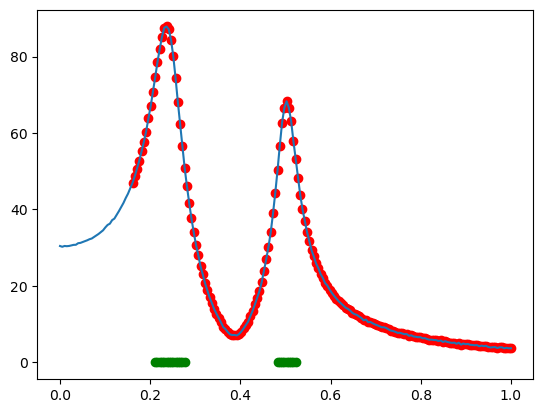

In [ ]:
index = 8

test_op = np.array(val_outputs[index].numpy())
predicted = (test_op > 0.0).astype(int)
targets = np.array(val_targets[index].numpy())
print(targets)

fig, ax = plot_tf(val_inputs[index].numpy(), predicted)
w = np.linspace(0, 1, len(targets))
for i in range(len(w)):
    if targets[i] == 1:
        ax.scatter(w[i], 0, c='green', marker='o')
# plt.show()

In [12]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, num_classes):
        # calls parent class constructor
        super(BiLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True, dropout=0.3)
        # hidden_size * 2 because we are using a bidirectional RNN (double the length of the hidden state)
        self.fc = nn.Linear(hidden_size*2, num_classes)
        self.droput = nn.Dropout(0.3)
        
    def forward(self, x):
        out, _ = self.lstm(x)
        # Pass each time step's output through a fully connected layer
        out = self.fc(out)
        out = self.droput(out)
        # out = torch.sigmoid(out)
        return out

In [13]:
def train_model(model, X, y, valX, valy, name, num_epochs=150):

    X = torch.from_numpy(X).to(torch.float32)
    y = torch.from_numpy(y).to(torch.float32)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.float32)

    dataset = TensorDataset(X, y)
    train_loader = DataLoader(dataset, batch_size=32, shuffle=True, pin_memory=True, num_workers=4)

    val_dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

    # Define a binary cross-entropy loss function and an optimizer
    # pos_weight > 1 aims to increase recall
    criterion = nn.BCEWithLogitsLoss(pos_weight = torch.tensor([4.0]))  # Binary cross-entropy loss with logits
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        total_loss = 0.0
        total_precision = 0.0
        total_recall = 0.0
        total_samples = 0

        total_val_precision = 0.0
        total_val_recall = 0.0
        total_val_samples = 0

        model.train()

        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs)
            
            # Reshape the outputs and targets for the loss calculation
            outputs = outputs.view(-1, 1)  # Reshape to [batch_size * sequence_length, 1]
            targets = targets.view(-1, 1)
            
            loss = criterion(outputs, targets.float())  # Convert targets to float
            loss.backward()
            optimizer.step()

            batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
            total_loss += loss.item() * len(inputs)
            total_precision += batch_precision * len(inputs)
            total_recall += batch_recall * len(inputs)
            total_samples += len(inputs)

        model.eval() # !!!
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs)
                outputs = outputs.view(-1, 1)
                targets = targets.view(-1, 1)

                batch_precision, batch_recall = calculate_precision_and_recall(outputs, targets)
                total_val_precision += batch_precision * len(inputs)
                total_val_recall += batch_recall * len(inputs)
                total_val_samples += len(inputs)

        average_loss = total_loss / total_samples
        average_precision = total_precision / total_samples
        average_recall = total_recall / total_samples
        # average_accuracy = total_accuracy / total_samples
        average_val_precision = total_val_precision / total_val_samples
        average_val_recall = total_val_recall / total_val_samples

        # print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Accuracy: {average_accuracy}')
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {average_loss}, Precision: {average_precision}, Recall: {average_recall}')
        print(f'Validation Precision: {average_val_precision}, Validation Recall: {average_val_recall}')


    torch.save(model, f'{name}.pth')

In [ ]:
X, y, _, __ = generate_data(32*500,200)
valX, valy, _, __ = generate_data(32*100, 200)

model2 = BiLSTM(input_size, hidden_size, num_layers, num_classes)
train_model(model2, X, y, valX, valy, 'lstm_model', num_epochs=100)

Epoch [1/100], Loss: 0.42704496705532075, Precision: 0.8571817010036891, Recall: 0.6616242589129543
Validation Precision: 0.9293653111297062, Validation Recall: 0.6630868913489519
Epoch [2/100], Loss: 0.3741303988695145, Precision: 0.9208349730736197, Recall: 0.6794199334687331
Validation Precision: 0.9542674889580628, Validation Recall: 0.6685354770425492
Epoch [3/100], Loss: 0.36407903039455414, Precision: 0.9331734969248603, Recall: 0.6836795794418414
Validation Precision: 0.9220465715179309, Validation Recall: 0.6872778102330781
Epoch [4/100], Loss: 0.35712472969293596, Precision: 0.9407970458412407, Recall: 0.6869150936211822
Validation Precision: 0.935196069142557, Validation Recall: 0.6883517612486582
Epoch [5/100], Loss: 0.3539079427719116, Precision: 0.945510263449665, Recall: 0.6868695945965536
Validation Precision: 0.95986733970838, Validation Recall: 0.679418144723927
Epoch [6/100], Loss: 0.35025555646419526, Precision: 0.9499600872667472, Recall: 0.6881816170900121
Validat

In [186]:
lstm_1 = torch.load('lstm_model.pth')
validate_data(100,lstm_1)


Validation Precision: 0.9805130970501067, Validation Recall: 0.992566898885297


In [ ]:
model2.eval()
for val_inputs, val_targets in val_loader:
    with torch.no_grad():
        val_outputs = model(val_inputs)

In [14]:
def plot_predictions(val_inputs, val_outputs, val_targets):

    fig, axs = plt.subplots(nrows = 4, ncols = 4, figsize=(12,12))
    w = np.linspace(0, 1, len(val_targets[0]))
    for index, ax in enumerate(axs.flat):

        targets = np.array(val_targets[index].numpy())
        test_op = np.array(val_outputs[index].numpy())
        predicted = (test_op > 0.0).astype(int)

        ax.plot(w, to_db(val_inputs[index].numpy()))
        for i in range(len(w)):
            if predicted[i] == 1:
                ax.scatter(w[i], to_db(val_inputs[index].numpy())[i], c='red', marker='o')
            if targets[i] == 1:
                ax.scatter(w[i], 0, c='green', marker='o')

    plt.tight_layout()

In [ ]:
valX, valy, _, __ = generate_data(32*1, 200)
val_X = torch.from_numpy(valX).to(torch.float32)
val_y = torch.from_numpy(valy).to(torch.float32)

dataset = TensorDataset(val_X, val_y)
val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

model2.eval()
for val_inputs, val_targets in val_loader:
    with torch.no_grad():
        val_outputs = model2(val_inputs)

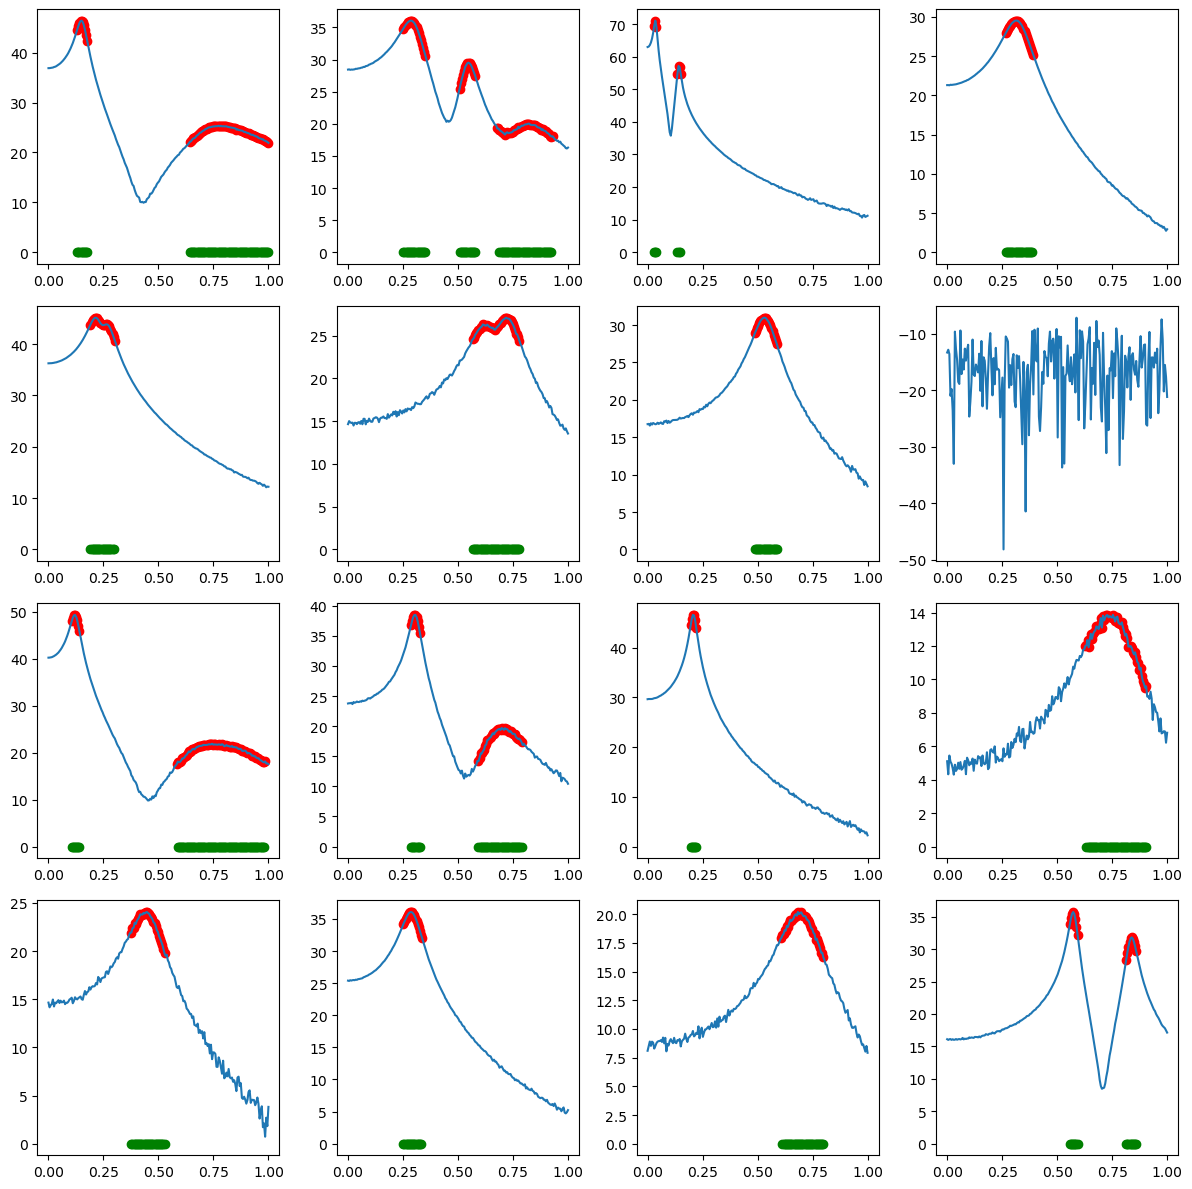

In [ ]:
plot_predictions(val_inputs, val_outputs, val_targets)

In [ ]:
Xrnn, yrnn, _, __ = generate_data(32*500,200)
valXrnn, valyrnn, _, __ = generate_data(32*100, 200)

model2rnn = BiRNN(input_size, hidden_size, num_layers, num_classes)
train_model(model2rnn, Xrnn, yrnn, valXrnn, valyrnn, 'rnn_v2', num_epochs=100)


Epoch [1/100], Loss: 0.4765524619221687, Precision: 0.7877311463843977, Recall: 0.6489118738559252
Validation Precision: 0.8760843696432238, Validation Recall: 0.8957836558256566
Epoch [2/100], Loss: 0.4467254755496979, Precision: 0.826359322001419, Recall: 0.655774194022568
Validation Precision: 0.8840370182585778, Validation Recall: 0.8832256619828597
Epoch [3/100], Loss: 0.44414635574817657, Precision: 0.8307266902808887, Recall: 0.6572014551946203
Validation Precision: 0.885179126911228, Validation Recall: 0.9109567715786401
Epoch [4/100], Loss: 0.4409098379611969, Precision: 0.8373420832569137, Recall: 0.6556980885585675
Validation Precision: 0.8699278006570482, Validation Recall: 0.9241475155034573
Epoch [5/100], Loss: 0.4398213763833046, Precision: 0.8342080449975703, Recall: 0.6587298906587291
Validation Precision: 0.8446106546245741, Validation Recall: 0.9494206129092908
Epoch [6/100], Loss: 0.42705845725536346, Precision: 0.8522558135754057, Recall: 0.6610593419156744
Validat

In [15]:
def compare_models(model1, model2):
    valX, valy, _, __ = generate_data(32*1, 200)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.float32)

    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model1.eval()
    model2.eval()
    for val_inputs, val_targets in val_loader:
        with torch.no_grad():
            val_outputs1 = model1(val_inputs)
            val_outputs2 = model2(val_inputs)

    plot_predictions(val_inputs, val_outputs1, val_targets)
    plot_predictions(val_inputs, val_outputs2, val_targets)


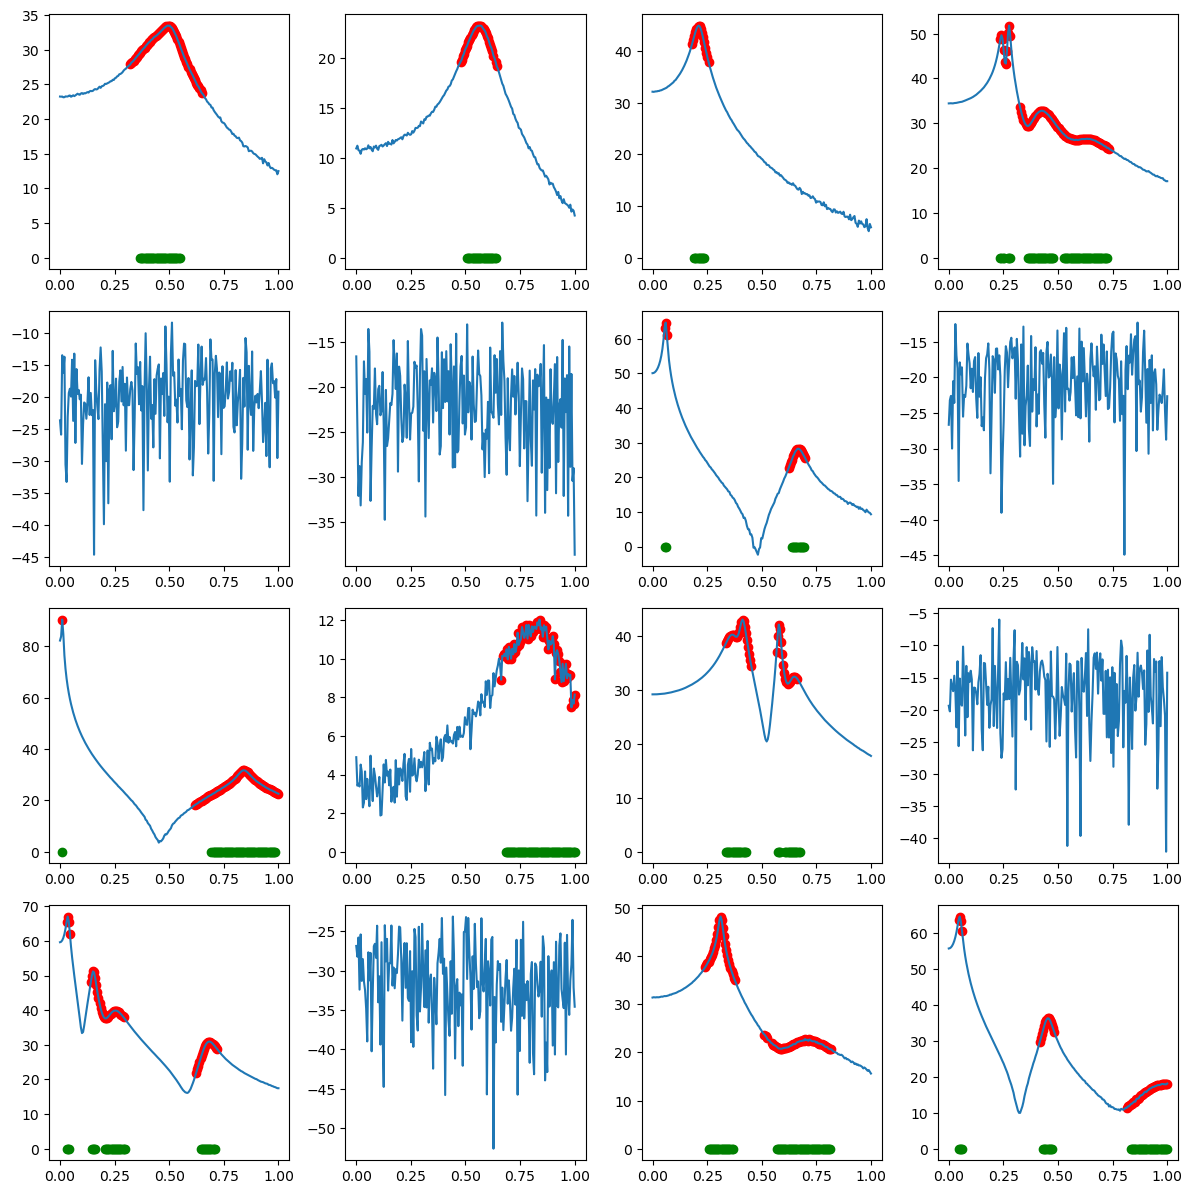

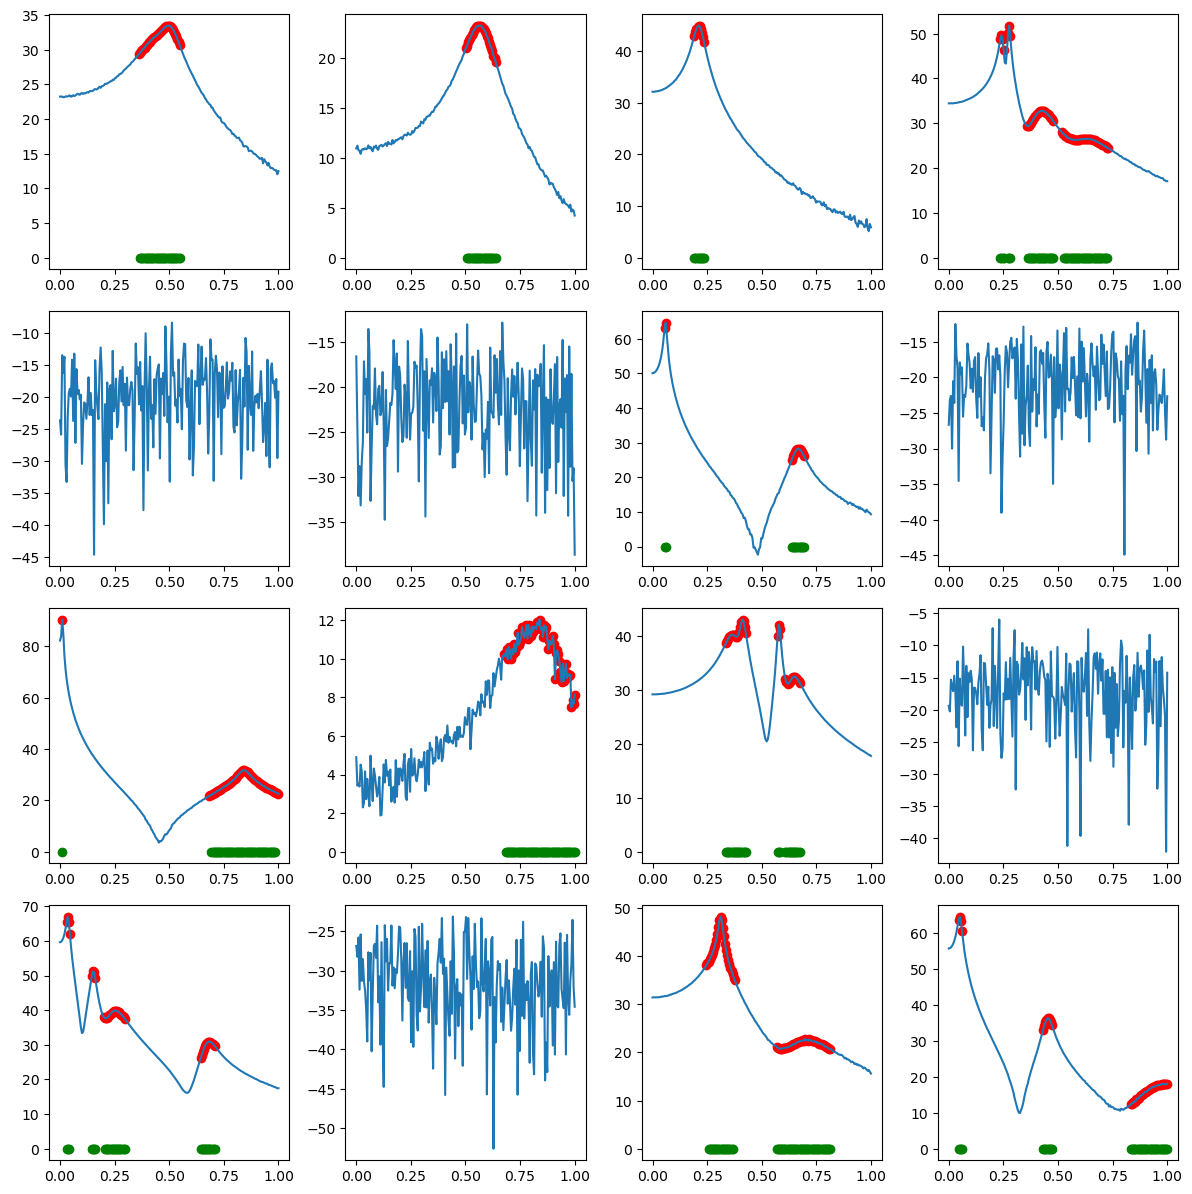

In [17]:
rnn_model = torch.load("rnn_v2.pth")
lstm_model = torch.load("lstm_model.pth")
compare_models(rnn_model, lstm_model)


In [16]:
def generate_noisy_data(num_data, num_w_points):
    X = []
    Y = []
    ws = []
    zs = []
    w = np.linspace(0, 1, num_w_points)
    for i in range(num_data):
        num_modes = np.random.randint(0, 6)
        w_n = np.random.uniform(0, 1, num_modes)
        a_n = np.random.uniform(1, 2, num_modes)
        z_n = np.random.uniform(0.01, 0.20, num_modes)
        sigma = np.random.uniform(0.01, 1.0)
        out, y = modal_sum(w, a_n, z_n, w_n, sigma)
        ws.append(w_n)
        zs.append(z_n)
        X.append(split_real_imag(out))
        Y.append(y)
    return np.array(X), np.array(Y), ws, zs

In [17]:
def validate_model(model, noisy=False):
    if noisy:
        valX, valy, _, __ = generate_noisy_data(32*1, 200)
    else:
        valX, valy, _, __ = generate_data(32*1, 200)
    val_X = torch.from_numpy(valX).to(torch.float32)
    val_y = torch.from_numpy(valy).to(torch.float32)

    dataset = TensorDataset(val_X, val_y)
    val_loader = DataLoader(dataset, batch_size=32, shuffle=False)

    model.eval()
    for val_inputs, val_targets in val_loader:
        with torch.no_grad():
            val_outputs = model(val_inputs)

    plot_predictions(val_inputs, val_outputs, val_targets)

In [101]:
X, y, _, __ = generate_noisy_data(32*550,200)
valX, valy, _, __ = generate_noisy_data(32*100, 200)

lstm_2 = BiLSTM(input_size, hidden_size, num_layers, num_classes)
train_model(lstm_2, X, y, valX, valy, 'lstm_model_2', num_epochs=100)

Epoch [1/100], Loss: 0.4615441702712666, Precision: 0.8622939748127537, Recall: 0.6658529737895506
Validation Precision: 0.9176504488805094, Validation Recall: 0.9680071623159263
Epoch [2/100], Loss: 0.4059852796251124, Precision: 0.9178551089977156, Recall: 0.6794975653609716
Validation Precision: 0.9373341627358641, Validation Recall: 0.9794985609653085
Epoch [3/100], Loss: 0.3929488961263136, Precision: 0.9321184075212564, Recall: 0.6835801284612903
Validation Precision: 0.9464145952293143, Validation Recall: 0.9743858335677615
Epoch [4/100], Loss: 0.3867010561986403, Precision: 0.939341619339768, Recall: 0.6851369589847603
Validation Precision: 0.9591240348254669, Validation Recall: 0.970270058257411
Epoch [5/100], Loss: 0.38174666827375237, Precision: 0.9441779254997164, Recall: 0.68778102740803
Validation Precision: 0.9524349171532593, Validation Recall: 0.9845982160144001
Epoch [6/100], Loss: 0.38035732903263786, Precision: 0.9463956973536888, Recall: 0.6876722092115058
Validati

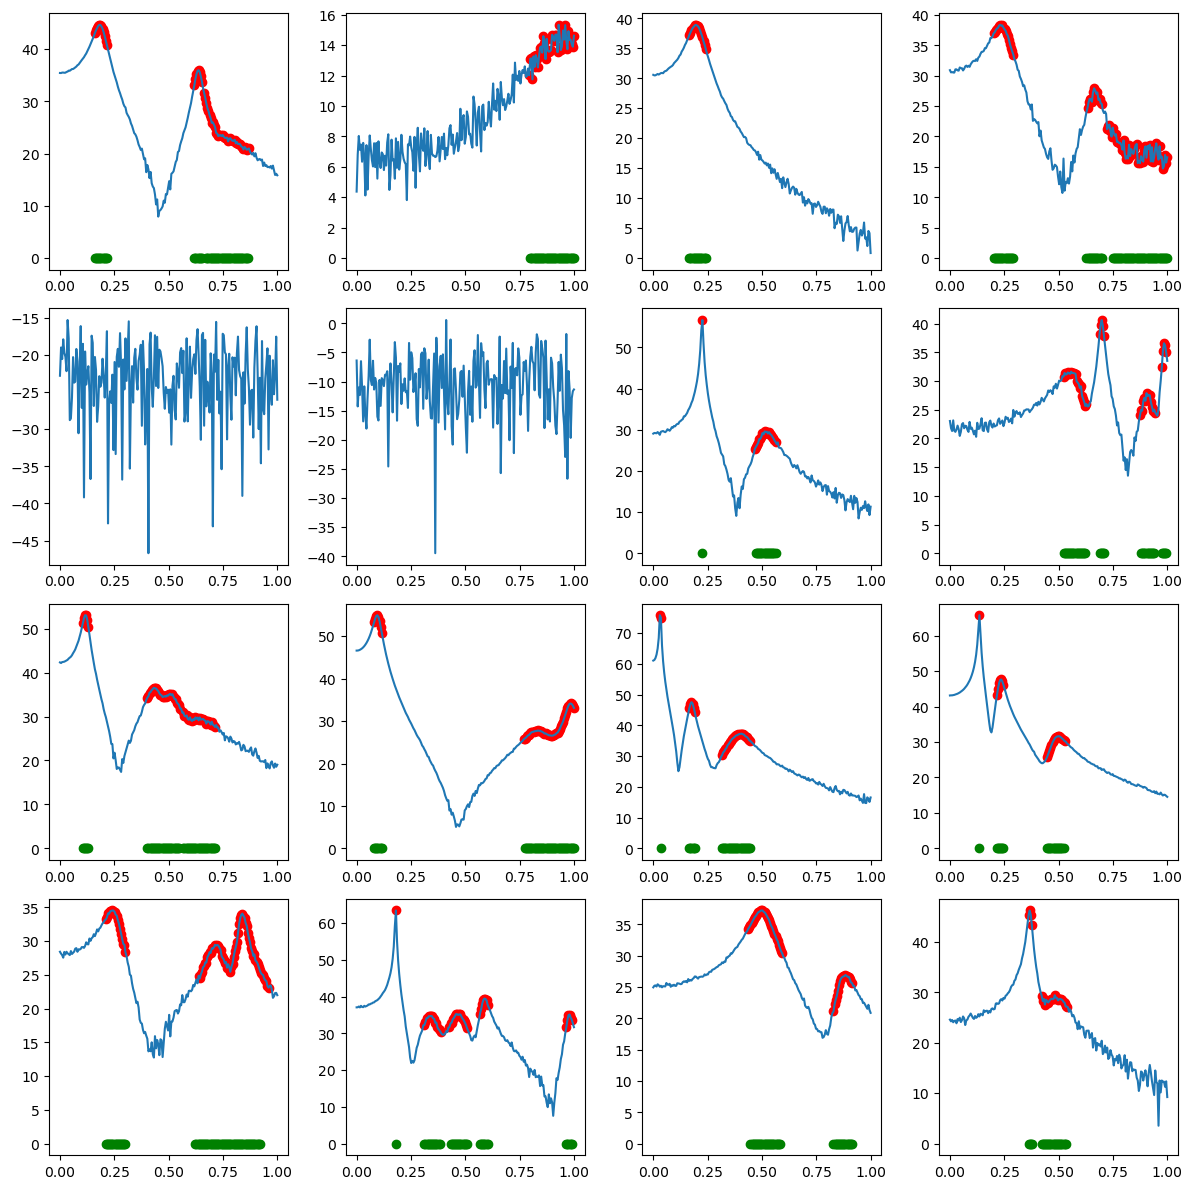

In [106]:
validate_model(lstm_2, noisy=True)

torch.Size([32, 500, 1])


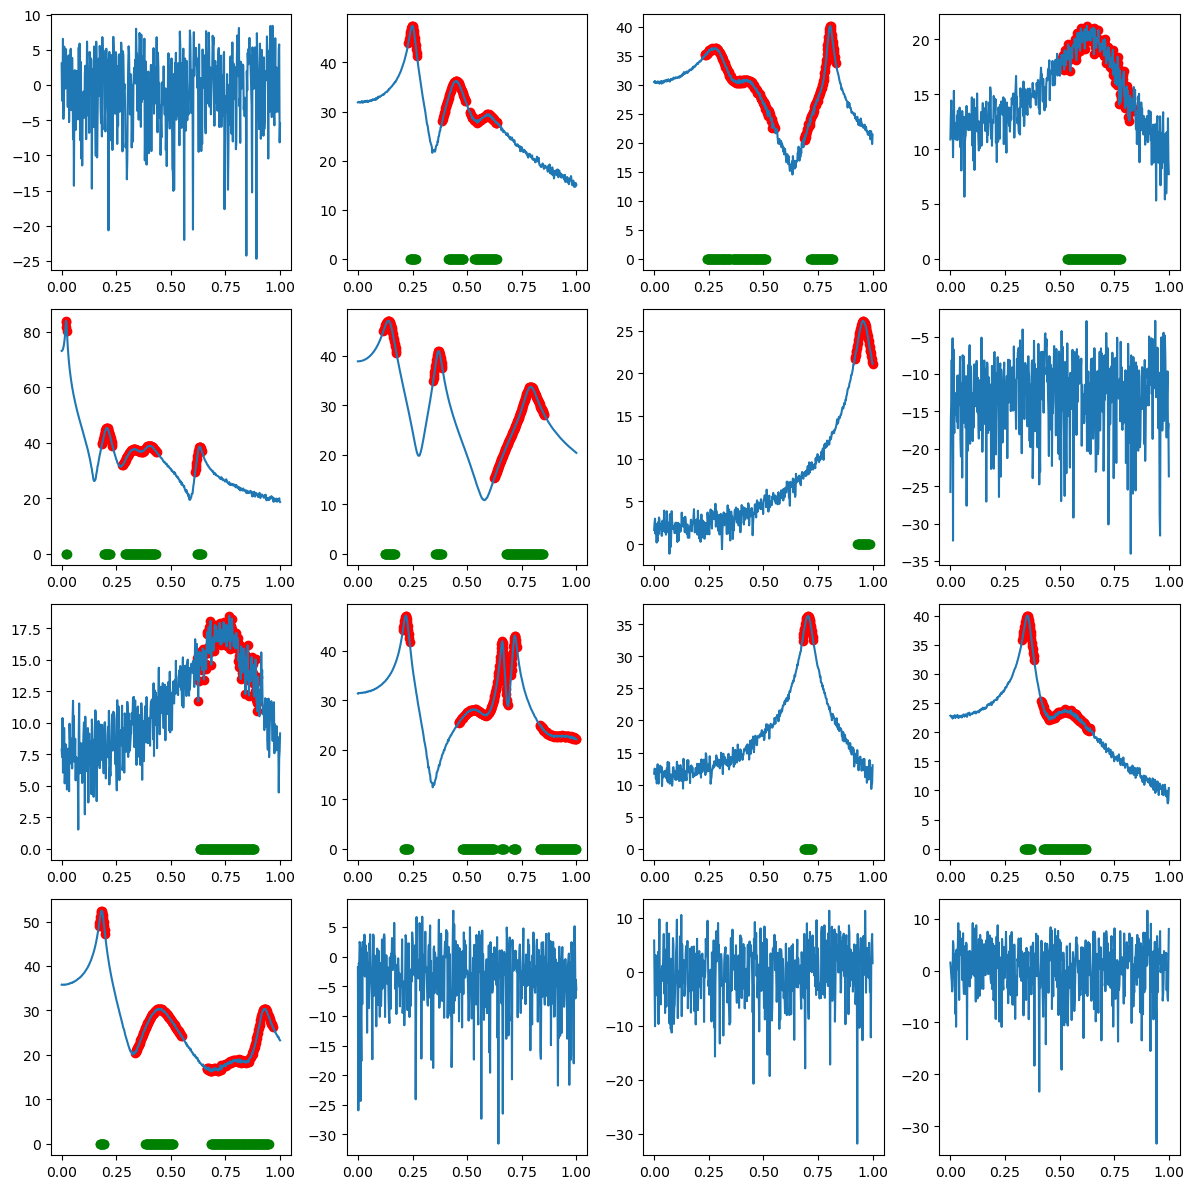

In [114]:
test_long_X, test_long_y, _, _ = generate_noisy_data(32, 500)
test_long_X = torch.from_numpy(test_long_X).to(torch.float32)
test_long_y = torch.from_numpy(test_long_y).to(torch.float32)
lstm_2.eval()
with torch.no_grad():
    test_long_outputs = lstm_2(test_long_X)

print(test_long_outputs.shape)

plot_predictions(test_long_X, test_long_outputs, test_long_y)

In [18]:
import pydvma as dvma

In [19]:
d = dvma.load_data()
tf_data = d.tf_data_list[0]
tf_arr = np.array(tf_data.tf_data)
print(tf_arr.shape)

2023-11-12 00:17:39.240 python[11374:746055] +[CATransaction synchronize] called within transaction


(8183, 1)


In [20]:
# Convert from velocity to displacement transfer function
# Ingnore first frequency due to divide by zero issues

freq_axis = tf_data.freq_axis.reshape(1,-1,1)
real_input = split_real_imag(tf_arr / 1j).reshape(1,-1,2)
processed = real_input[:,1:,:] / (freq_axis[:,1:,:])

print(processed)

[[[ 2.07633905e-02 -2.86935661e-02]
  [ 1.35287263e-02 -4.56022449e-03]
  [ 1.60646882e-03 -4.22275085e-03]
  ...
  [-5.85654739e-08  5.65486908e-06]
  [-2.01824900e-07  5.23696548e-06]
  [ 0.00000000e+00  5.26440540e-06]]]


(<Figure size 640x480 with 1 Axes>, <Axes: >)

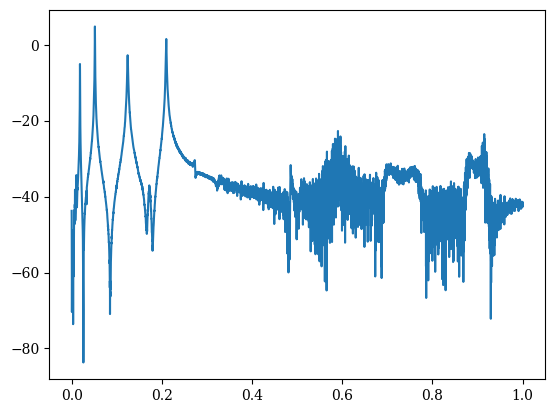

In [54]:
lstm_2 = torch.load("lstm_model_2.pth")
lstm_2.eval()
with torch.no_grad():
    real_output = lstm_2(torch.from_numpy(processed).to(torch.float32))
real_output_numpy = real_output.numpy().reshape(-1)
predictions = (real_output_numpy > 0.0).astype(int)
input_tf = split_real_imag(tf_arr)

plot_tf(input_tf[1:], predictions)


In [25]:
def preprocess_data(X):
    # Normalise data between -1 and 1
    min_vals = np.min(X, axis=1, keepdims=True)
    max_vals = np.max(X, axis=1, keepdims=True)
    X_norm= (X-min_vals) / (max_vals-min_vals)
    X_norm = -1 + 2 * X_norm
    return X_norm

In [167]:
X, y, _, __ = generate_noisy_data(32*500,200)
valX, valy, _, __ = generate_noisy_data(32*100, 200)
X = preprocess_data(X)
lstm_pre_1 = BiLSTM(input_size, hidden_size, num_layers, num_classes)
train_model(lstm_pre_1, X, y, valX, valy, 'lstm_preprocess_minmax', num_epochs=25)

KeyboardInterrupt: 

In [24]:
def preprocess_data_2(X):
    X_norm = X / np.linalg.norm(X, axis=0, keepdims=True)
    return X_norm

(<Figure size 640x480 with 1 Axes>, <Axes: >)

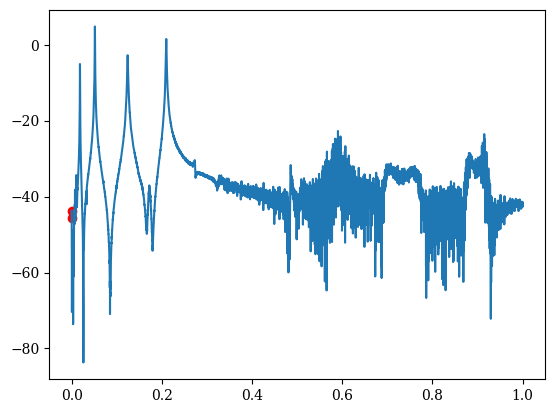

In [72]:
rescaled = processed
lstm_2 = torch.load("lstm_preprocess_norm.pth")
lstm_2.eval()
with torch.no_grad():
    real_output = lstm_2(torch.from_numpy(rescaled).to(torch.float32))
real_output_numpy = real_output.numpy().reshape(-1)
predictions = (real_output_numpy > 0.0).astype(int)
input_tf = split_real_imag(tf_arr)

plot_tf(input_tf[1:], predictions)

In [161]:
X, y, _, __ = generate_noisy_data(32*500,200)
valX, valy, _, __ = generate_noisy_data(32*100, 200)
X = preprocess_data_2(X)
lstm_pre_2 = BiLSTM(input_size, hidden_size, num_layers, num_classes)
train_model(lstm_pre_2, X, y, valX, valy, 'lstm_preprocess_norm', num_epochs=100)

Epoch [1/100], Loss: 1.0401219139695168, Precision: 0.22581189484716835, Recall: 0.15740830800311473
Validation Precision: 0.23608761534925612, Validation Recall: 1.0
Epoch [2/100], Loss: 0.46454693806171415, Precision: 0.8712664170387755, Recall: 0.6650962880888076
Validation Precision: 0.23959634678173153, Validation Recall: 1.0
Epoch [3/100], Loss: 0.4197743520736694, Precision: 0.9140439934518795, Recall: 0.6776963049930619
Validation Precision: 0.2420305889507556, Validation Recall: 1.0
Epoch [4/100], Loss: 0.538227013528347, Precision: 0.8531749471258537, Recall: 0.6388067592996699
Validation Precision: 0.2426881892531446, Validation Recall: 1.0
Epoch [5/100], Loss: 0.43090611094236375, Precision: 0.8962501204251885, Recall: 0.6753354191463757
Validation Precision: 0.2549080930188145, Validation Recall: 0.9998654734626133
Epoch [6/100], Loss: 0.40814829301834105, Precision: 0.9203736412086326, Recall: 0.6804605387659975
Validation Precision: 0.2594599255195419, Validation Recall:

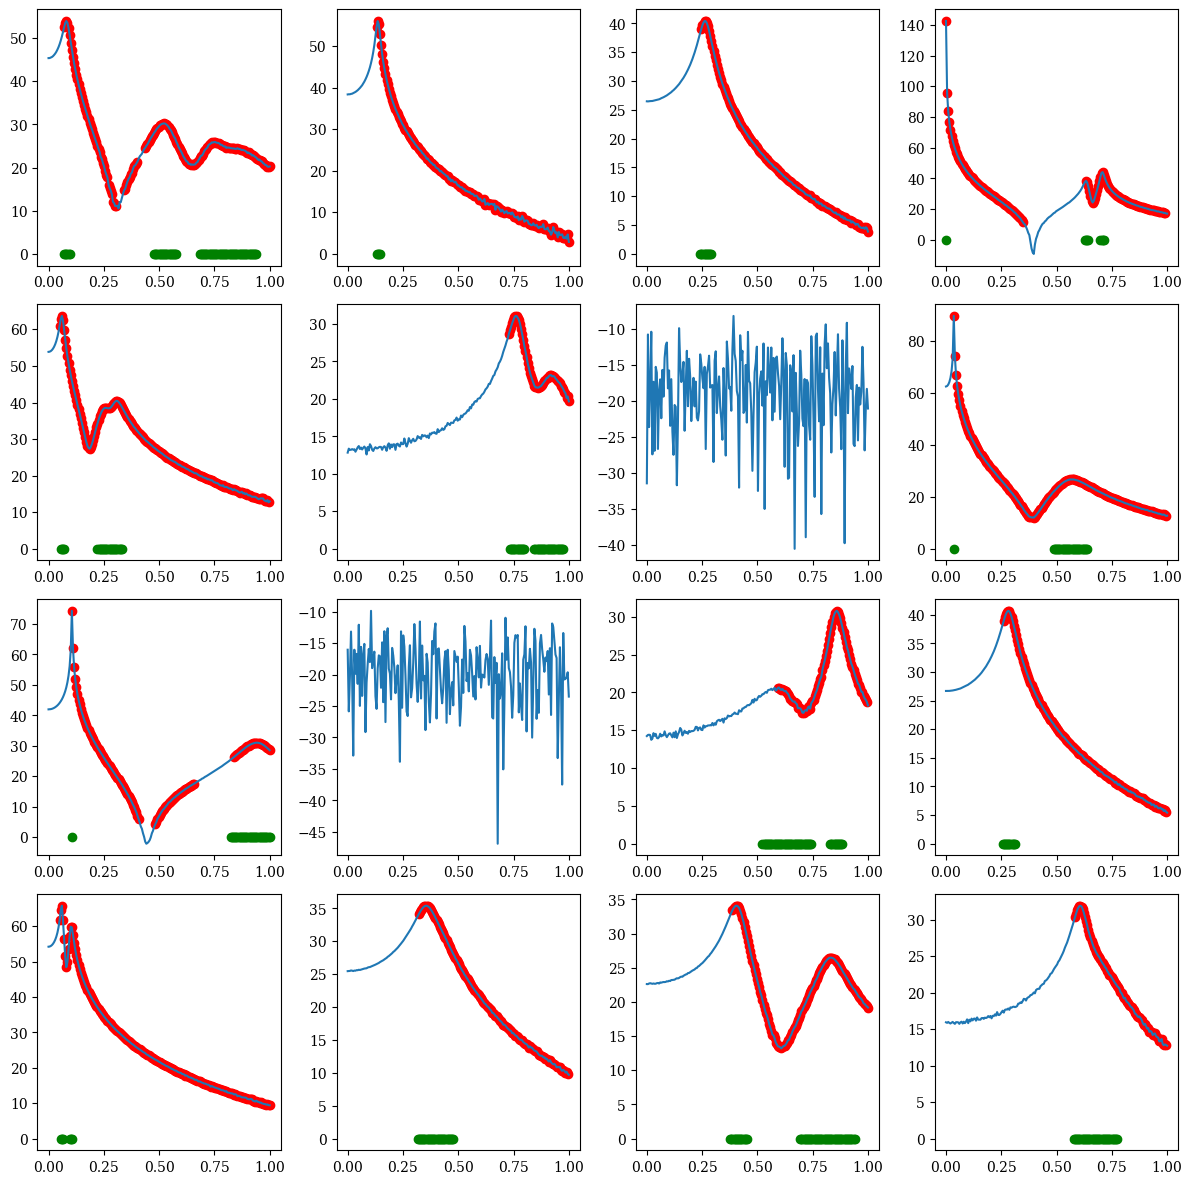

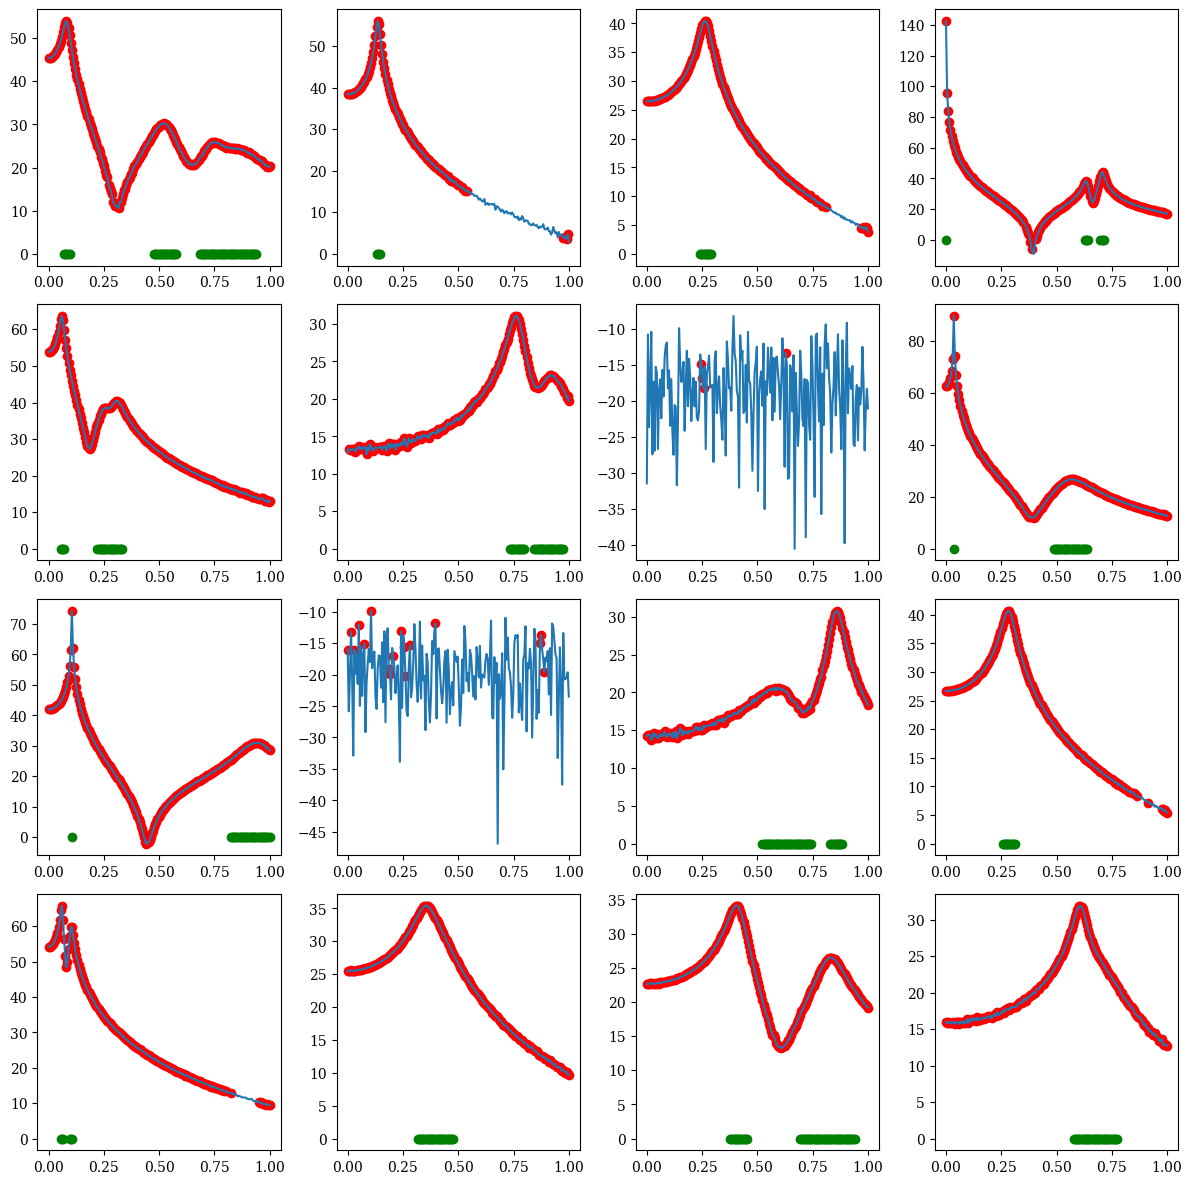

In [164]:
compare_models(lstm_pre_1, lstm_pre_2)

(8182,)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

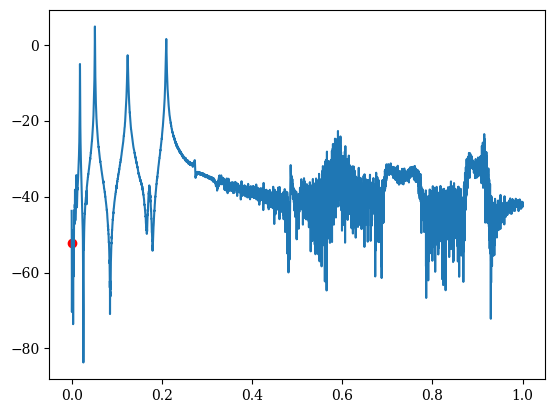

In [76]:
real_input_preprocess = preprocess_data(processed)
# real_input_preprocess = processed
real_input_tensor = torch.from_numpy(real_input_preprocess).to(torch.float32)
lstm_pre_1 = torch.load("lstm_preprocess_minmax.pth")
lstm_pre_1.eval()
with torch.no_grad():
    real_output = lstm_pre_1(real_input_tensor)

real_output_numpy = real_output.numpy().reshape(-1)
predictions = (real_output_numpy > 0.0).astype(int)
input_tf = split_real_imag(tf_arr)

print(predictions.shape)
plot_tf(input_tf[1:], predictions)


In [31]:
real_input_preprocess = preprocess_data_2(processed)
real_input_tensor = torch.from_numpy(real_input_preprocess).to(torch.float32)
lstm_pre_2.eval()
with torch.no_grad():
    real_output = lstm_pre_2(real_input_tensor)

real_output_numpy = real_output.numpy().reshape(-1)
predictions = (real_output_numpy > 0.0).astype(int)
input_tf = split_real_imag(tf_arr)

plot_tf(input_tf, predictions)

/var/folders/mw/j7jd8sy576gdhd74r9ppm1qc0000gn/T/ipykernel_11374/318455544.py:2: RuntimeWarning: invalid value encountered in divide
  X_norm = X / np.linalg.norm(X, axis=0, keepdims=True)


NameError: name 'lstm_pre_2' is not defined

In [43]:
print(real_input)
print(np.max(real_input, axis=1))

print(real_input.shape)
print(np.linalg.norm(real_input[:,:,0], axis=1, keepdims=True))
print(np.linalg.norm(real_input[:,:,1], axis=1))

print(real_input[:,:,1])

dodgy_processing = np.zeros(shape=real_input.shape)
dodgy_processing[:,:,0] = real_input[:,:,0] / np.linalg.norm(real_input[:,:,0], axis=1, keepdims=True)
dodgy_processing[:,:,1] = real_input[:,:,1] / 1j*np.linalg.norm(real_input[:,:,1], axis=1, keepdims=True)
print(dodgy_processing)

    

[[[ 0.00000000e+00 -5.46236378e-03]
  [ 3.80653700e-03 -5.26037021e-03]
  [ 4.96042276e-03 -1.67204515e-03]
  ...
  [-8.78267374e-05  8.48023021e-03]
  [-3.02700350e-04  7.85448813e-03]
  [ 0.00000000e+00  7.89660810e-03]]]
[[0.7684163  1.69949832]]
(1, 8183, 2)
[[5.15396185]]
[5.24936423]
[[-0.00546236 -0.00526037 -0.00167205 ...  0.00848023  0.00785449
   0.00789661]]
[[[ 0.00000000e+00  0.00000000e+00]
  [ 7.38565227e-04  0.00000000e+00]
  [ 9.62448482e-04  0.00000000e+00]
  ...
  [-1.70406262e-05  0.00000000e+00]
  [-5.87315854e-05  0.00000000e+00]
  [ 0.00000000e+00  0.00000000e+00]]]


/var/folders/mw/j7jd8sy576gdhd74r9ppm1qc0000gn/T/ipykernel_11374/3317300406.py:12: ComplexWarning: Casting complex values to real discards the imaginary part
  dodgy_processing[:,:,1] = real_input[:,:,1] / 1j*np.linalg.norm(real_input[:,:,1], axis=1, keepdims=True)


/var/folders/mw/j7jd8sy576gdhd74r9ppm1qc0000gn/T/ipykernel_11374/318455544.py:2: RuntimeWarning: invalid value encountered in divide
  X_norm = X / np.linalg.norm(X, axis=0, keepdims=True)


(<Figure size 640x480 with 1 Axes>, <Axes: >)

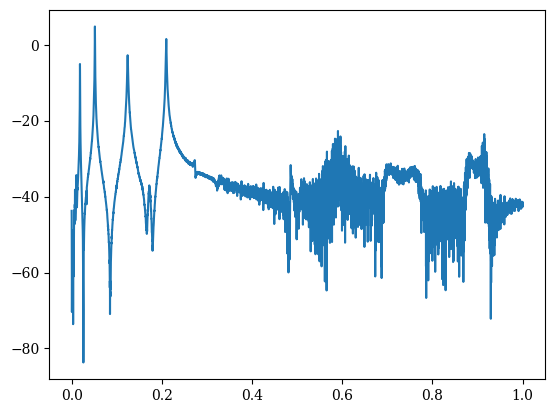

In [45]:
lstm_v2 = torch.load("lstm_preprocess_norm.pth")
# real_input_preprocess = preprocess_data(real_input)
real_input_preprocess = preprocess_data_2(processed)
# real_input_preprocess = dodgy_processing
real_input_tensor = torch.from_numpy(real_input_preprocess).to(torch.float32)

# real_input_tensor = torch.from_numpy(dodgy_processing).to(torch.float32)

lstm_v2.eval()
with torch.no_grad():
    real_output = lstm_v2(real_input_tensor)

real_output_numpy = real_output.numpy().reshape(-1)
predictions = (real_output_numpy > 0.0).astype(int)
input_tf = split_real_imag(tf_arr)

# plot_tf(input_tf[:3000], predictions[:3000], todb=True)
plot_tf(input_tf[1:], predictions, todb=True)

Calculating the number of parameters of different models

In [74]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [75]:
lstm_1 = torch.load("lstm_model.pth")
lstm_2 = torch.load("lstm_model_2.pth")
rnn_1 = torch.load("precision_recall_model.pth")
rnn_2 = torch.load("rnn_v2.pth")
lstm_pre_1 = torch.load("lstm_preprocess_minmax.pth")
lstm_pre_2 = torch.load("lstm_preprocess_norm.pth")

models = [lstm_1, lstm_2, rnn_1, rnn_2, lstm_pre_1, lstm_pre_2]
names = ["lstm_1", "lstm_2", "rnn_1", "rnn_2", "lstm_pre_1", "lstm_pre_2"]

for model, name in zip(models, names):
    print(f"{name} has {count_parameters(model)} parameters")

lstm_1 has 566601 parameters
lstm_2 has 566601 parameters
rnn_1 has 141801 parameters
rnn_2 has 141801 parameters
lstm_pre_1 has 566601 parameters
lstm_pre_2 has 566601 parameters
